# Here we will Clean images that we scrapped from Google

## Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from math import ceil
%matplotlib inline

## Load Image

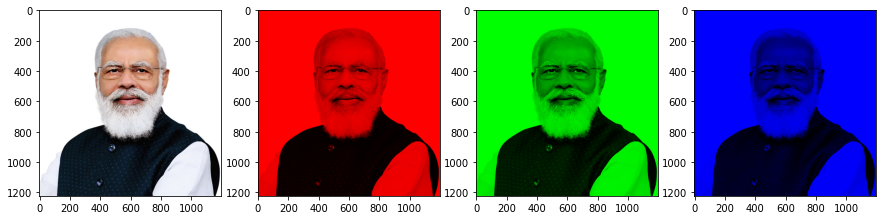

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(15, 10))
img = plt.imread('./Images/Narendra_Modi/Narendra_Modi_0.jpg')
red = img.copy()
blue = img.copy()
green = img.copy()


red[:, :, 1] = red[:, :, 2] = 0
green[:, :, 0] = green[:, :, 2] = 0
blue[:, :, 0] = blue[:, :, 1] = 0

axes[0].imshow(img)
axes[1].imshow(red)
axes[2].imshow(green)
axes[3].imshow(blue)

# Detecting face from whole image

## 1. OpenCV's Harscascade model to detect face and eyes.

* But the `minSize` parameter needed to be changed for each image as each image was of different size.
* This is not fesible so we discarded it

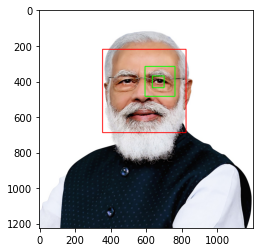

In [5]:
img = plt.imread('./Images/Narendra_Modi/Narendra_Modi_0.jpg')
face_path = './haarcascade_frontalface_default.xml'
eye_path = './haarcascade_eye.xml'
face_detector = cv2.CascadeClassifier(face_path)
eye_detector = cv2.CascadeClassifier(eye_path)

faces = face_detector.detectMultiScale(img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(100, 100),
        flags = cv2.CASCADE_SCALE_IMAGE)

eyes = eye_detector.detectMultiScale(img,
        scaleFactor=1.1,
        minNeighbors=5, 
        minSize=(30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE)


for face in faces:
    x, y, w, h = face
    img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)
    
for eye in eyes:
    x, y, w, h = eye
    img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

plt.imshow(img)

In [6]:
faces

array([[356, 220, 468, 468]])

In [7]:
eyes

array([[635, 370,  66,  66],
       [594, 316, 168, 168]])

## 2. Yolo to detect face

* After OpenCV's Harscascade model failed we decided to use yoloface
* yoloface is grate liberary and it is easy to detect face using it

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


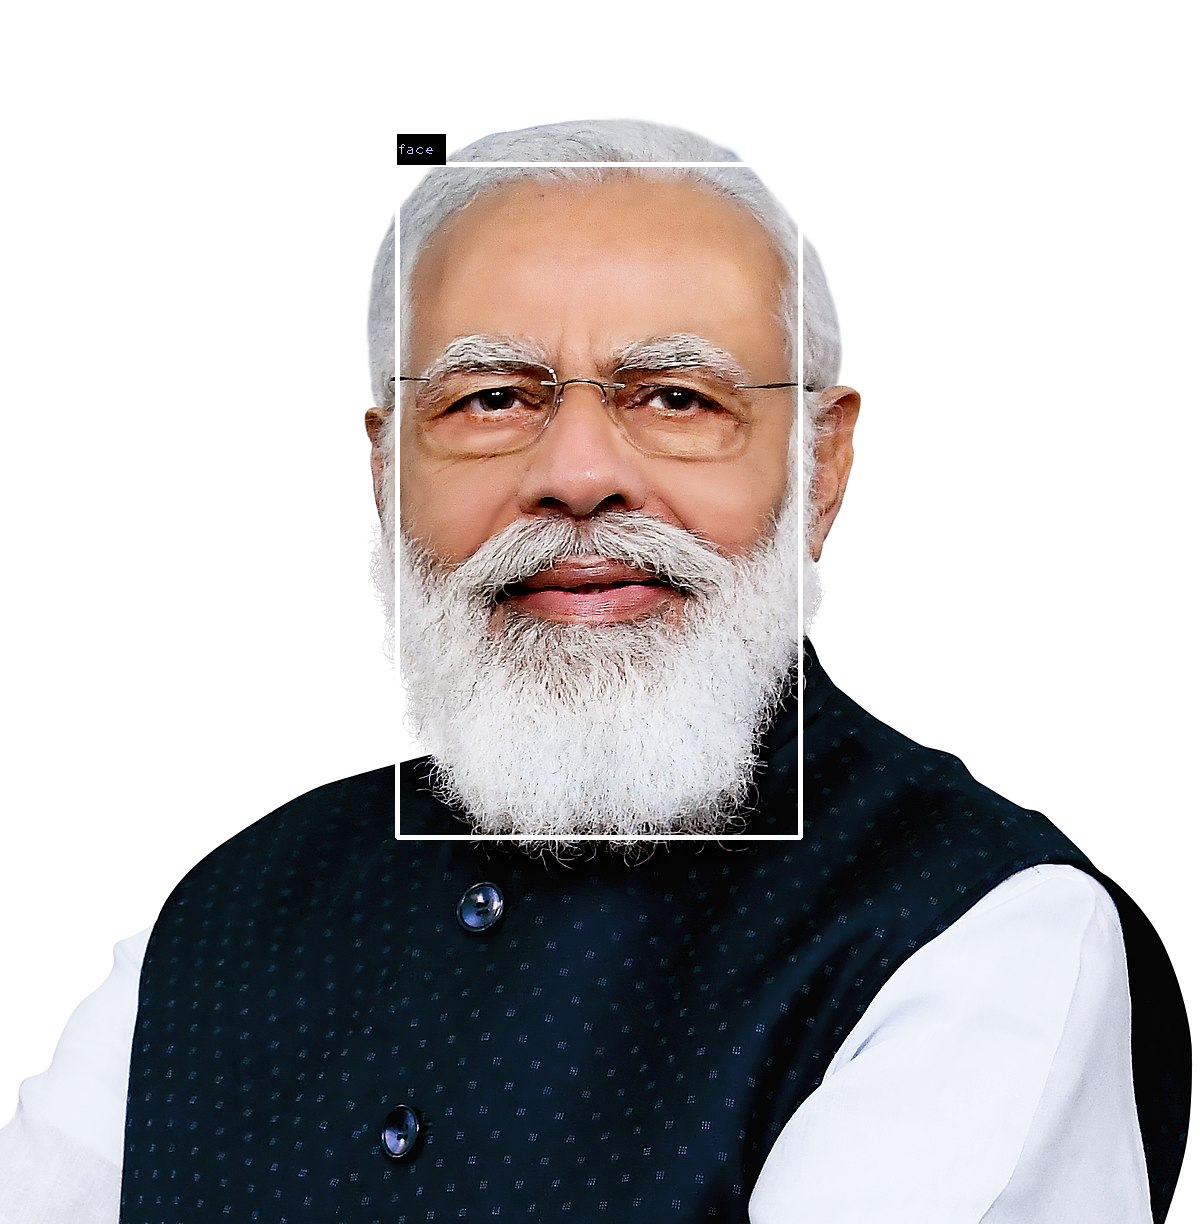

In [8]:
from yoloface import face_analysis
face = face_analysis()
img, box, conf = face.face_detection(image_path='./Images/Narendra_Modi/Narendra_Modi_0.jpg', model='full')
face.show_output(img, box)

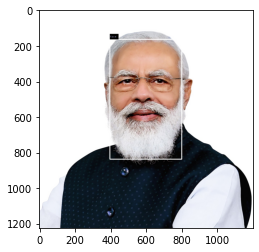

In [9]:
plt.imshow(cv2.cvtColor(img, cv2.COLORMAP_WINTER))

In [10]:
conf

[0.8666077256202698]

In [11]:
box

[[397, 164, 673, 403]]

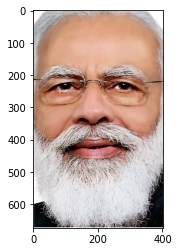

In [12]:
x, y, h, w = box[0]
img = img[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(img, cv2.COLORMAP_WINTER))

In [13]:
encoded_labels = {name: idx for idx, name in enumerate(['Sanna Marin', 'Narendra Modi', 'Vladimir Putin', 
                                                'Tsai Ing-wen', 'Iván Duque Márquez', 'Alberto Fernández', 
                                                'Joe Biden', 'Felix Tshisekedi', 'Jacinda Ardern', 'Carlos Alvarado Quesada'])}
encoded_labels

{'Sanna Marin': 0,
 'Narendra Modi': 1,
 'Vladimir Putin': 2,
 'Tsai Ing-wen': 3,
 'Iván Duque Márquez': 4,
 'Alberto Fernández': 5,
 'Joe Biden': 6,
 'Felix Tshisekedi': 7,
 'Jacinda Ardern': 8,
 'Carlos Alvarado Quesada': 9}

In [14]:
label_reverse_lookup = {idx: name for name, idx in encoded_labels.items()}
label_reverse_lookup

{0: 'Sanna Marin',
 1: 'Narendra Modi',
 2: 'Vladimir Putin',
 3: 'Tsai Ing-wen',
 4: 'Iván Duque Márquez',
 5: 'Alberto Fernández',
 6: 'Joe Biden',
 7: 'Felix Tshisekedi',
 8: 'Jacinda Ardern',
 9: 'Carlos Alvarado Quesada'}

### Here using yoloface we are detecting face and cropping only image

In [16]:
from yoloface import face_analysis
face = face_analysis()
def crop_image(img_path):
    img, boxes, confs = face.face_detection(image_path=img_path, model='full')
    faces = []
    for box in boxes:
        x, y, h, w = box
        tmp = img[y:y+h, x:x+w]
        faces.append(tmp)
    return imgs, confs

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


In [17]:
def load_images(path):
    imgs = []
    labels = []

    for dirpaths, dirnames, filenames in os.walk(path):
        if "ipynb" in dirpaths:
            continue

        for file in filenames:        
            label = encoded_labels.get(' '.join(dirpaths.split('_')).split('/')[-1])
            try:
                images, confs = crop_image(dirpaths+'/'+file)
                for img, conf in zip(images, confs):
                    if conf > 0.80:
                        imgs.append(img)
                        labels.append(label)
            except:
                print(f"Unable to load : {dirpaths+'/'+file}")
    return imgs, labels

In [18]:
def pop_smaller_imgs(imgs, labels, size):
    removed_imgs = []
    removed_labels = []
    for idx, img in enumerate(imgs):
        if img.shape[0] < (size[0]//2) or img.shape[1] < (size[1]//2) or img.shape[2] != 3:
            print(f"Removing image : {idx} : {img.shape}")
            
            removed_imgs.append(img)
            removed_labels.append(labels[idx])
            
            imgs.pop(idx)
            labels.pop(idx)
    return (removed_imgs, removed_labels), (imgs, labels) 

In [19]:
def resize_imgs(imgs, labels, size):
    removed, good = pop_smaller_imgs(imgs, labels, size)
    imgs, labels = good
    x = []
    y = []
    weird_size = size[1], size[0]
    
    for img, label in zip(imgs, labels):
        try:
            if size[0] < img.shape[0] and size[1] < img.shape[1]:
                # This is For shrinking an Image
                tmp = cv2.resize(img, weird_size, interpolation=cv2.INTER_AREA)
            elif size[0] > img.shape[0] and size[1] > img.shape[1]:
                # This is for Enlarging an image
                tmp = cv2.resize(img, weird_size, interpolation=cv2.INTER_CUBIC)
            else:
                # This is default behaviour
                tmp = cv2.resize(img, weird_size) 
                
            x.append(tmp)
            y.append(label)
            
        except Exception as msg:
            # print(f"\n {msg}")
            print(f"Unable to resize image with shape : {img.shape} to size : {size}")
    
    return x, y

In [20]:
def generate_npy_files(path, size):
    imgs, labels = load_images(path)
    imgs, labels = resize_imgs(imgs, labels, size)
    
    imgs = np.asarray(imgs, dtype=np.uint8)
    labels = np.asarray(labels, dtype=np.uint8)
    
    imgs_path = path + '/Images_' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    labels_path = path + '/Labels_' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    
    np.save(imgs_path, imgs)
    np.save(labels_path, labels)

In [21]:
def load_numpy_arrays(path, size, load_cleaned=True):
    clean_imgs_path = path + '/Images_Clean' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    clean_labels_path = path + '/Labels_Clean' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    
    if load_cleaned and os.path.exists(clean_imgs_path) and os.path.exists(clean_labels_path):
        print('Found Cleaned data for given dim.')
        imgs = np.load(clean_imgs_path)
        labels = np.load(clean_labels_path)
        return imgs, labels
    
    if load_cleaned and ((not os.path.exists(clean_imgs_path)) or (not os.path.exists(clean_labels_path))):
        print('Cleaned Images do  not exist loading unclean images')
        
    
    imgs_path = path + '/Images_' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    labels_path = path + '/Labels_' + str(size[0]) + 'x' + str(size[1]) + '.npy'
    
    if not os.path.exists(imgs_path) or not os.path.exists(labels_path):
        print('numpy array are not stored generating them...')
        generate_npy_files(path, size) 
    
    imgs = np.load(imgs_path)
    labels = np.load(labels_path)
    
    return imgs, labels

In [22]:
# imgs = np.load('./Images150/OldNpy/Images_80x40.npy')
# labels = np.load('./Images150/OldNpy/Labels_80x40.npy')
# imgs.shape

In [23]:
root_image_path = './Images'
size = (60, 40, 3)

In [24]:
imgs, labels = load_numpy_arrays(root_image_path, size)

Found Cleaned data for given dim.


In [25]:
imgs.shape

(922, 60, 40, 3)

In [26]:
# imgs = np.load('./Images150/Images_Clean60x40.npy')
# labels = np.load('./Images150/Labels_Clean60x40.npy')
# imgs.shape

In [27]:
def data_validation(imgs, labels, label_to_plot):
    idx = 0
    total_images_of_given_label = np.count_nonzero(labels == label_to_plot)
    fig, axes = plt.subplots(ceil(total_images_of_given_label/10), 10, figsize=(22, 42))
    plt.axis('off')
    for index, data in enumerate(zip(imgs, labels)):
        img, label = data
        if label != label_to_plot:
            continue
        axes[idx//10][idx%10].xaxis.set_visible(False)
        axes[idx//10][idx%10].yaxis.set_visible(False)
        axes[idx//10][idx%10].imshow(cv2.cvtColor(img, cv2.COLORMAP_WINTER))
        axes[idx//10][idx%10].title.set_text(f"{label_reverse_lookup[label].split(' ')[0]} : {index}")
        idx += 1

In [28]:
# data_validation(imgs, labels, 0)

In [29]:
# IMAGES150 : 60X40 : 0 : 230 234 240 253 255 257 260 262 263 283 289 301 323 324 325 326 340 350 354 355
# IMAGES150 : 60X40 : 1 : 1066 1067 1078 1081 1086 1103 1112 1115 1116 1127 1129 1134 1135 1138 1144 1154 1159
# IMAGES150 : 60X40 : 2 : 488 508 517 520 521 536 541 542 543 552 556 560 573 584 586 590 594
# IMAGES150 : 60X40 : 3 : 842 845 854 856 858 866 879 886 902 907 909 911 912 917 922 923 925 926 938 947 949 950 954 964
# IMAGES150 : 60X40 : 4 : 976 977 984 991 992 994 995 998 1000 1009 1010 1013 1015 1017 1021 1025 1026 1030 1031 1044 1045 1047 1051 1054 1059 1062 1064
# IMAGES150 : 60X40 : 5 : 107 108 116 117 126 127 136 142 145 146 148 153 154 156 157 160 164 165 173 174 177 179 181 187 192 197 198 200 201 206 212 217 224 227
# IMAGES150 : 60X40 : 6 : 736 737 740 746 749 754 755 763 765 775 776 784 785 786 790 797 801 802 804 809 810 822 829
# IMAGES150 : 60X40 : 7 : 10 12 13 14 25 27 36 40 46 47 52 53 54 57 58 62 63 67 69 73 75 85 86 87 89 91 92 98 99
# IMAGES150 : 60X40 : 8 : 614 624 627 630 656 658 659 664 673 668 691 692 706 714 715 725 730 732
# IMAGES150 : 60X40 : 9 : 362 363 366 368 371 373 374 392 394 400 401 405 419 420 423 424 426 427 428 440 442 445 447 454 456 460 461 472 474 476

C:\Users\Murli's Lappy\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

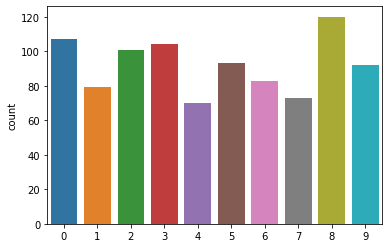

In [30]:
sns.countplot(labels)

In [31]:
# # def clean_data(imgs, labels, path, save=True):
# imgs_path = root_image_path + '/Images_Clean' + str(size[0]) + 'x' + str(size[1]) + '.npy'
# labels_path = root_image_path + '/Labels_Clean' + str(size[0]) + 'x' + str(size[1]) + '.npy'
# idx_to_remove = []
# for i in encoded_labels.values():
#     # data_validation(imgs, labels, i)
#     idx_to_remove.extend(list(map(int, input(f"Enter index to remove wrong images of {label_reverse_lookup[i]} with idx : {i} : ").split())))

# print(idx_to_remove)

# is_valid = input("Validate above list those images will be removed <y/N> : ")

# if is_valid != "y":
#     print("exiting....")
#     exit(0)

# imgs = np.delete(imgs, idx_to_remove, axis=0)
# labels = np.delete(labels, idx_to_remove)

# np.save(imgs_path, imgs)
# np.save(labels_path, labels)

#     # return imgs, labels

In [32]:
# idx = 0
# images_to_plt = len(
# fig, axes = plt.subplots(ceil(total_images_of_given_label/10), 10, figsize=(22, 42))
# plt.axis('off')
# for index, data in enumerate(zip(imgs, labels)):
#     img, label = data
#     if label != label_to_plot:
#         continue
#     axes[idx//10][idx%10].xaxis.set_visible(False)
#     axes[idx//10][idx%10].yaxis.set_visible(False)
#     axes[idx//10][idx%10].imshow(cv2.cvtColor(img, cv2.COLORMAP_WINTER))
#     axes[idx//10][idx%10].title.set_text(f"{label_reverse_lookup[label].split(' ')[0]} : {index}")
#     idx += 1

In [33]:
imgs.shape

(922, 60, 40, 3)

C:\Users\Murli's Lappy\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

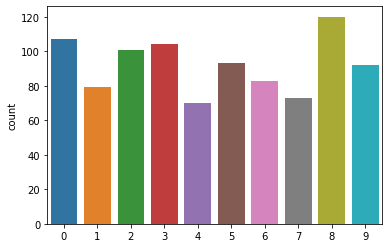

In [34]:
sns.countplot(labels)

In [35]:
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.1)

In [36]:
train_labels.shape

(829,)

In [37]:
test_labels.shape

(93,)

In [38]:
size

(60, 40, 3)

In [39]:
x = tf.random.normal((10, 60, 40, 3))
y = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=size)(x)
y = tf.keras.layers.AveragePooling2D((6, 4))(x)
y.shape

TensorShape([10, 10, 10, 3])

In [40]:
checkpoint_path = f'{root_image_path}/TF_Model_Checkpoints/'

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GaussianDropout, \
LayerNormalization, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, \
GlobalMaxPooling2D, Conv2D, MaxPool2D, MaxPooling2D, MaxPool3D, MaxPooling3D

input_shape=(60, 40, 2)
model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=train_imgs.shape[1:], activation=tf.nn.relu),
    AveragePooling2D(),
    Dropout(0.1),
    
    # Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu),
    # Conv2D(filters=8, kernel_size=(3, 3), activation=tf.nn.relu),
    # Conv2D(filters=2, kernel_size=(3, 3), activation=tf.nn.relu),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    AveragePooling2D(),
    Dropout(0.1),
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    AveragePooling2D(),
    Dropout(0.1),
    
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    AveragePooling2D(),
    Dropout(0.1),
    
    # Conv2D(filters=3, kernel_size=(3, 3), activation=tf.nn.relu),
    # AveragePooling2D((2, 2)),
    # Conv2D(filters=2, kernel_size=(3, 3), activation=tf.nn.relu),
    # AveragePooling2D((6, 4)),
    
    # Conv2D(filters=3, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=train_imgs.shape[1:]),
    # # MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(filters=3, kernel_size=(3, 3), activation=tf.nn.relu),
    # # MaxPooling2D(pool_size=(4, 4)),
    # Conv2D(filters=3, kernel_size=(3, 3), activation=tf.nn.relu),
    # # AveragePooling2D((2, 2)),
    # # Conv2D(filters=3, kernel_size=(3, 3), activation=tf.nn.relu),
    # # AveragePooling2D((2, 2)),
    # Conv2D(filters=2, kernel_size=(3, 3), activation=tf.nn.relu),
    # AveragePooling2D((2, 2)),
    
    Flatten(),
    
    # Dense(800, activation=tf.nn.relu),
    # Dense(800, activation=tf.nn.relu),
    # Dense(400, activation=tf.nn.relu),
    # Dropout(0.05),
    # Dense(200, activation=tf.nn.relu),
    # Dense(50, activation=tf.nn.relu),
    
    # Dense(600, activation=tf.nn.relu),
    Dense(500, activation=tf.nn.relu),
    
    # GaussianDropout(0.05),
    
    # Dense(400, activation=tf.nn.relu),
    # Dense(300, activation=tf.nn.relu),
    
    # Dropout(0.05),
    
    Dense(250, activation=tf.nn.relu),
    # Dense(100, activation=tf.nn.relu),
    # Dense(50, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.softmax)
])

BATCH_SIZE = 15
STEPS_PER_EPOCH = train_labels.size / BATCH_SIZE
SAVE_PERIOD = 10


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq= int(SAVE_PERIOD * STEPS_PER_EPOCH))

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [42]:
class_weights = { label: (labels.shape[0] / (10 * np.count_nonzero(labels == label))) for label in labels }
class_weights

{7: 1.263013698630137,
 5: 0.9913978494623656,
 0: 0.8616822429906542,
 9: 1.0021739130434784,
 2: 0.9128712871287129,
 8: 0.7683333333333333,
 6: 1.110843373493976,
 3: 0.8865384615384615,
 4: 1.3171428571428572,
 1: 1.1670886075949367}

C:\Users\Murli's Lappy\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

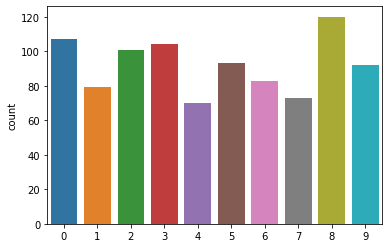

In [43]:
sns.countplot(labels)

In [44]:
epochs = 55

In [45]:
# class weight

history = model.fit(train_imgs, train_labels, validation_data=(test_imgs, test_labels),
                    batch_size=BATCH_SIZE, epochs=epochs,
                    steps_per_epoch=STEPS_PER_EPOCH, callbacks=[cp_callback],
                    class_weight=class_weights, use_multiprocessing=True)

Epoch 1/55
55/55 [==============================] - 1s 18ms/step - loss: 3.3555 - accuracy: 0.1255 - val_loss: 2.1751 - val_accuracy: 0.2796
Epoch 2/55
55/55 [==============================] - 1s 16ms/step - loss: 1.8824 - accuracy: 0.3390 - val_loss: 1.4416 - val_accuracy: 0.4086
Epoch 3/55
55/55 [==============================] - 1s 16ms/step - loss: 1.4367 - accuracy: 0.4668 - val_loss: 1.2780 - val_accuracy: 0.5161
Epoch 4/55
55/55 [==============================] - 1s 16ms/step - loss: 1.1082 - accuracy: 0.5826 - val_loss: 0.9509 - val_accuracy: 0.5914
Epoch 5/55
55/55 [==============================] - 1s 16ms/step - loss: 0.9525 - accuracy: 0.6393 - val_loss: 0.9758 - val_accuracy: 0.5591
Epoch 6/55
55/55 [==============================] - 1s 15ms/step - loss: 0.8625 - accuracy: 0.6852 - val_loss: 0.8104 - val_accuracy: 0.6989
Epoch 7/55
55/55 [==============================] - 1s 16ms/step - loss: 0.7074 - accuracy: 0.7419 - val_loss: 1.6988 - val_accuracy: 0.5699
Epoch 8/55
55

Epoch 54/55
55/55 [==============================] - 1s 16ms/step - loss: 0.0792 - accuracy: 0.9807 - val_loss: 0.8117 - val_accuracy: 0.8495
Epoch 55/55
55/55 [==============================] - 1s 16ms/step - loss: 0.2450 - accuracy: 0.9204 - val_loss: 0.6736 - val_accuracy: 0.8172


In [46]:
# import pickle

# file = open('./Images150/Model_test_acc_74.47_Image_size_60x40.pkl', 'rb')
# loded_model = pickle.load(file)
# file.close()

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 60, 40, 16)        448       
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 20, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 30, 20, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 20, 32)        4640      
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 10, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 15, 10, 32)        0

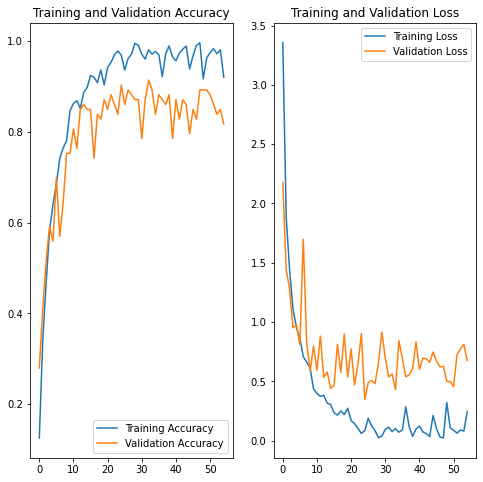

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
test_predictions = model.predict(test_imgs)
train_predictions = model.predict(train_imgs)

In [50]:
def predict(index):
    prediction = np.argmax(test_predictions[index])
    probability = np.max(test_predictions[index])
    plt.imshow(cv2.cvtColor(test_imgs[index], cv2.COLORMAP_WINTER))
    plt.title(f"Prediction = {label_reverse_lookup[prediction]}, Probability = {probability*100:.2f}%", y=1)
    plt.text(s=f"Label = {label_reverse_lookup[test_labels[index]]}", x=0, y=67)  

In [51]:
test_imgs.shape

(93, 60, 40, 3)

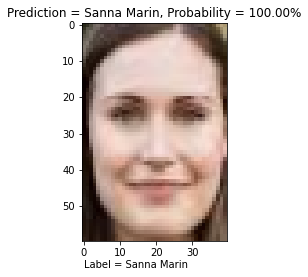

In [58]:
predict(9)

In [50]:
from sklearn.metrics import accuracy_score

test_preds = [np.argmax(prediction) for prediction in test_predictions]
test_accuracy = accuracy_score(test_labels, test_preds)
test_accuracy

0.956989247311828

In [51]:
train_preds = [np.argmax(prediction) for prediction in train_predictions]
accuracy_score(train_labels, train_preds)

1.0

In [52]:
test_labels

array([2, 8, 8, 6, 6, 8, 2, 3, 6, 0, 0, 1, 7, 3, 0, 2, 6, 8, 2, 8, 2, 2,
       0, 0, 9, 9, 8, 4, 3, 6, 6, 9, 9, 8, 0, 5, 0, 7, 2, 1, 0, 3, 9, 8,
       6, 0, 0, 2, 3, 3, 5, 5, 8, 9, 6, 0, 6, 1, 3, 5, 1, 7, 2, 4, 9, 0,
       0, 3, 2, 4, 5, 5, 6, 4, 3, 6, 7, 7, 8, 3, 1, 7, 5, 3, 9, 9, 2, 0,
       5, 5, 3, 0, 9], dtype=uint8)

In [53]:
np.asarray(test_preds, dtype=np.uint8)

array([2, 8, 8, 6, 6, 8, 2, 3, 6, 0, 0, 1, 7, 3, 0, 2, 6, 0, 2, 8, 2, 2,
       0, 0, 9, 9, 8, 4, 3, 6, 6, 9, 9, 8, 0, 5, 0, 7, 2, 1, 0, 3, 9, 8,
       6, 0, 0, 2, 3, 3, 5, 5, 9, 9, 6, 0, 6, 1, 3, 5, 1, 7, 2, 4, 9, 0,
       0, 3, 7, 4, 4, 5, 6, 4, 3, 6, 7, 7, 8, 3, 1, 7, 5, 3, 9, 9, 2, 0,
       5, 5, 3, 0, 9], dtype=uint8)

/home/user/Documents/DBDA/DBDA_Machine_Learning/Jupyter/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

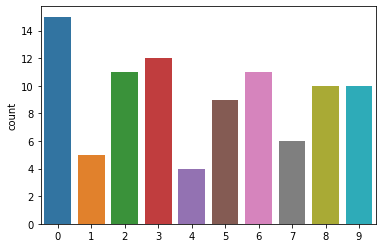

In [54]:
sns.countplot(test_labels)

/home/user/Documents/DBDA/DBDA_Machine_Learning/Jupyter/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

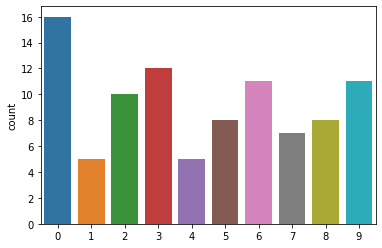

In [55]:
sns.countplot(test_preds)

In [56]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      1.00      1.00         5
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        12
           4       0.80      1.00      0.89         4
           5       1.00      0.89      0.94         9
           6       1.00      1.00      1.00        11
           7       0.86      1.00      0.92         6
           8       1.00      0.80      0.89        10
           9       0.91      1.00      0.95        10

    accuracy                           0.96        93
   macro avg       0.95      0.96      0.95        93
weighted avg       0.96      0.96      0.96        93



In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 60, 40, 16)        448       
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 20, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 30, 20, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 20, 32)        4640      
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 10, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 15, 10, 32)        0

In [58]:
# import pickle

# pickel_path = f"{root_image_path}/Model_test_acc_{test_accuracy*100:.2f}_Image_size_{size[0]}x{size[1]}_Mar31.pkl"
# test_data_path = f"{root_image_path}/Test_data_Model_acc_Mar31_{test_accuracy*100:.2f}_Image_size_{size[0]}x{size[1]}.npy"
# np.save(test_data_path, test_imgs)

# test_label_path = f"{root_image_path}/Test_label_Model_acc_Mar31_{test_accuracy*100:.2f}_Image_size_{size[0]}x{size[1]}.npy"
# np.save(test_label_path, test_labels)

# file = open(pickel_path, 'wb')
# pickle.dump(model, file)
# file.close()

In [59]:
# f = open('./Images150/Model_test_acc_76.34_Image_size_60x40_Feb11.pkl', 'rb')
# m = pickle.load(f)
# f.close()

In [60]:
# m.summary()